In [19]:
import sys,os
sys.path.append("../")
import random

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn

from utils.plots import visualize_uncertainty, save_fig
from utils.misc import gen_data
from utils.loss import AleatoricLoss
from utils.metrics import mpiw,picp
from model_utils.mlp import MLPNet
from uncertainty.mc_dropout_regression import mc_dropout_eval
from uncertainty.deep_ensemble_regression import deep_ensemble_eval,EnsembleRegressionModel
from uncertainty.bnn_svi_regression import bnn_svi_eval

In [20]:
%reload_ext autoreload
%autoreload 2

In [21]:
device = "cuda:0"
net = MLPNet(p=0.5, logvar=True, n_feature=1,
             n_hidden=32, n_output=1)
const_bnn_prior_parameters = {
    "prior_mu": 0.0,
    "prior_sigma": 1.0,
    "posterior_mu_init": 0.0,
    "posterior_rho_init": -3.0,
    "type":  "Reparameterization",## Flipout or Reparameterization
    "moped_enable": "",  # initialize mu/sigma from the dnn weights
    "moped_delta": 0.5,
}
dnn_to_bnn(net, const_bnn_prior_parameters)
checkpoint = torch.load("../saved_models/regression/bayesian/2023_12_26_13_50_27/mlp.pth",map_location=device)
net.load_state_dict(checkpoint)
net.to(device)

MLPNet(
  (hidden): LinearReparameterization()
  (mid1): LinearReparameterization()
  (mid2): LinearReparameterization()
  (mid3): LinearReparameterization()
  (mid4): LinearReparameterization()
  (predict): LinearReparameterization()
  (get_var): LinearReparameterization()
)

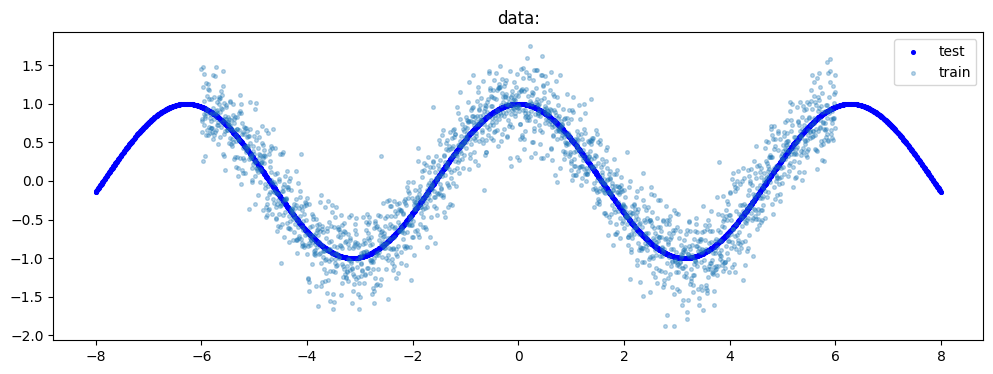

In [22]:
MEAN_FUN = np.cos
x_train, y_train, x_test, y_test = gen_data(mean_fun=MEAN_FUN,std_const=0.3,train_abs=6,test_abs=8,occlude=False, hetero=False)

In [25]:
preds,preds_mean,au,eu = bnn_svi_eval(net,x_test.to(device))
print(f"picp:{picp(preds,y_test.numpy())[0]:.2f}")
print(f"mpiw:{mpiw(preds,y_test.numpy()):.2f}")

picp:0.78
mpiw:1.19


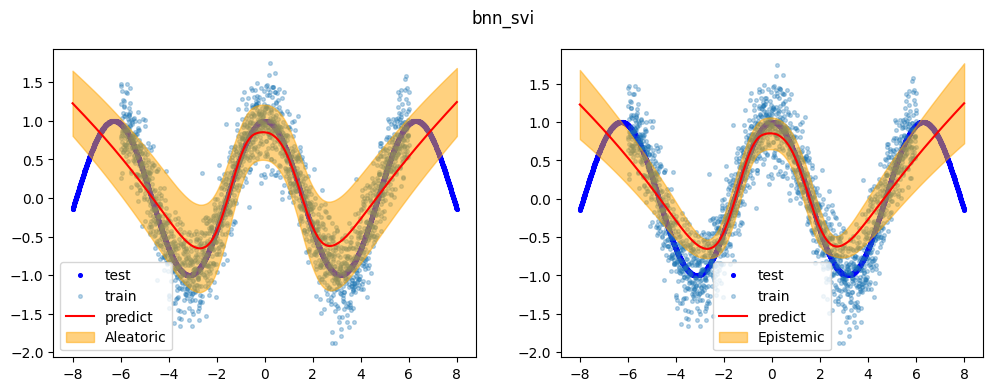

In [26]:
fig_title="bnn_svi"
fig = visualize_uncertainty(fig_title,preds_mean,au,eu, x_train, y_train, x_test, y_test )
save_fig(fig,"../results/bnn_svi_regression/","homo.jpg")